# Prediction using glmnet 

In [57]:
library(data.table)
library(caret)
library(pROC)
library(randomForest)
load("projetdatascience.rda")

In [59]:
projetValid$target="NA"

In [60]:
projetTrain = rbind(projetTrain,projetValid)

##### getting the emptiness ratio and number of factors foreach column and save the information in dataframe

In [61]:
vec_names         = names(projetTrain)
nb_lignes         = nrow(projetTrain)
vec_taux          = rep(0,length(vec_names))
vec_factors       = rep(0,length(vec_names))
index             = 1
data.informations = data.table(
                         feature=vec_names, 
                         taux=vec_taux,
                         factors=vec_factors
                        )


for(name in data.informations$feature){
    data.informations[index,  taux := (sum( is.na(projetTrain[,name, with=FALSE])) / nb_lignes)*100] 
    data.informations[index,factors:= length(table(projetTrain[,name, with=FALSE]))]
    index=index+1
}

##### saving in vectors the columns to factorise

In [62]:
columnsToFactor = data.informations[factors<10]$feature

In [63]:
projetTrain = projetTrain[,target:=ifelse(target==1,"OK","KO")] # transforming target from 1 0 to OK and KO

##### factorisation of columns that contains less than 10 unique values


In [64]:
for (feature in columnsToFactor) {    
    projetTrain[,feature:=as.factor(get(feature)),with=FALSE]
}
projetTrain$Product_Info_2 = as.factor(projetTrain$Product_Info_2)


##### filling NA values 

In [65]:
projetTrainClean = na.roughfix(projetTrain)

In [87]:
nb.rows = nrow(projetTrainClean)-nrow(projetValid)

In [88]:
projetTrain = projetTrainClean[1:nb.rows]

In [110]:
projetValid = projetTrainClean[(nb.rows+1):nrow(projetTrainClean)]

##### making subsets for train and test

In [93]:
set.seed(30)
split = sample(nrow(projetTrain), floor(0.3*nrow(projetTrain)))
sub.train = projetTrain[split,]
sub.test  = projetTrain[-split,]

In [94]:
lambda.grid = seq(0.005,0.007,length=10)
alpha.grid  = seq(0.43,0.6,length=10)
srchGrid    = expand.grid(.alpha=alpha.grid,.lambda=lambda.grid)
trnCtl      = trainControl(method="repeatedCV",number=5,repeats=2) # cadrage coss valisation

In [95]:
glmnet.model = train(target~.,data=sub.train,method="glmnet",tuneGrid=srchGrid,trControl=trnCtl,standardize=TRUE)#,maxit=1000000)

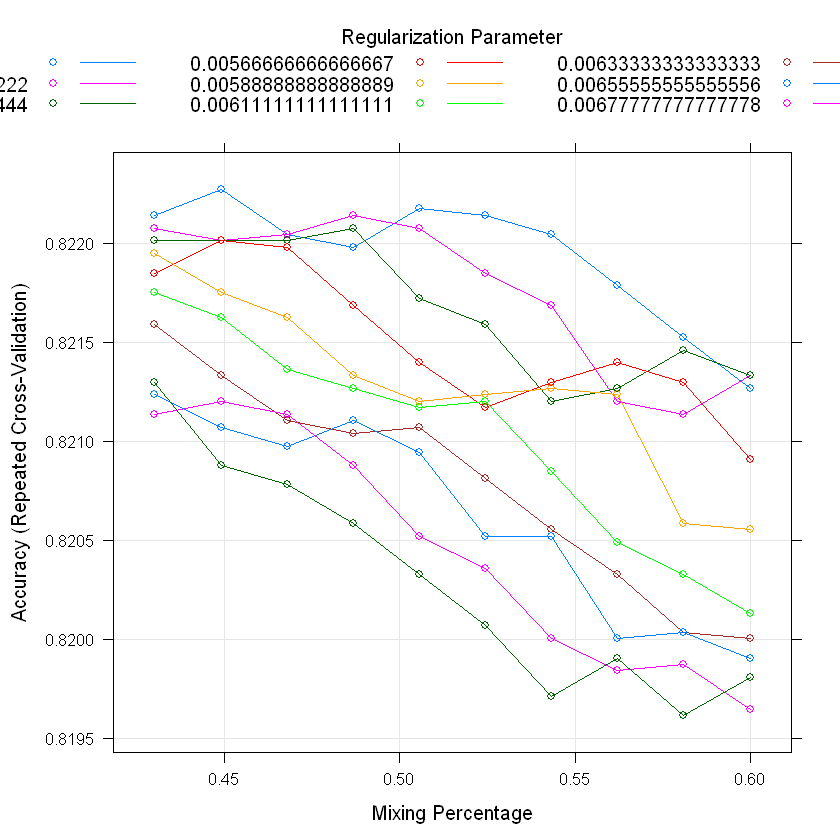

In [112]:
plot(glmnet.model) # visialusation des performances pour les diffï¿½rentes valeurs de alpha et beta"

##### model description

In [113]:
glmnet.model

glmnet 

15414 samples
  127 predictor
    2 classes: 'KO', 'OK' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 12331, 12331, 12332, 12331, 12331, 12330, ... 
Resampling results across tuning parameters:

  alpha      lambda       Accuracy   Kappa    
  0.4300000  0.005000000  0.8221425  0.5931911
  0.4300000  0.005222222  0.8220776  0.5929382
  0.4300000  0.005444444  0.8220128  0.5927105
  0.4300000  0.005666667  0.8218506  0.5922272
  0.4300000  0.005888889  0.8219480  0.5923995
  0.4300000  0.006111111  0.8217533  0.5919129
  0.4300000  0.006333333  0.8215911  0.5913442
  0.4300000  0.006555556  0.8212343  0.5903701
  0.4300000  0.006777778  0.8211370  0.5900070
  0.4300000  0.007000000  0.8212992  0.5902827
  0.4488889  0.005000000  0.8222723  0.5934481
  0.4488889  0.005222222  0.8220128  0.5928371
  0.4488889  0.005444444  0.8220128  0.5926303
  0.4488889  0.005666667  0.8220129  0.5925473
  0.4488889  0.005888889  0.8217533 

In [114]:
result.predicted.prob <- predict(glmnet.model, sub.test , type="prob") # Prediction


Call:
roc.default(response = sub.test$target, predictor = result.predicted.prob$OK)

Data: result.predicted.prob$OK in 24157 controls (sub.test$target KO) < 11810 cases (sub.test$target OK).
Area under the curve: 0.8995

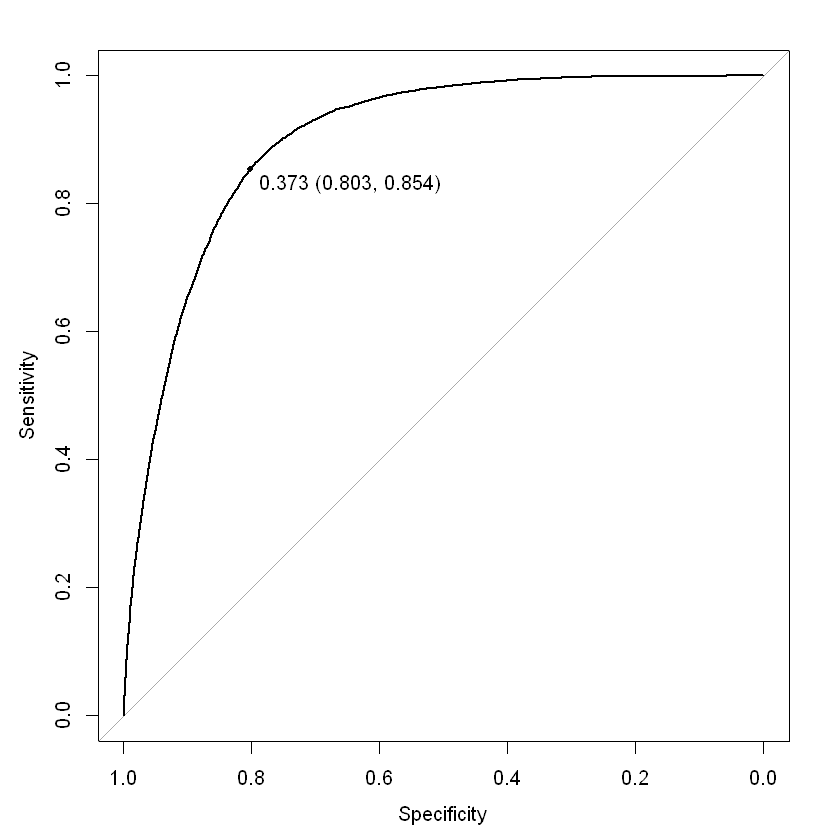

In [115]:
result.roc <- roc(sub.test$target, result.predicted.prob$OK) # Draw ROC curve.
plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")

In [116]:
save(glmnet.model, file="workspace_glmnet.Rdata")

##### generating the response for the validation subset

In [117]:
result.predicted.prob.valid <- predict(glmnet.model, projetValid , type="prob") # Prediction on validation subset

In [132]:
projetValid$Id = as.character(projetValid$Id)

In [133]:
validation.results = cbind(projetValid[,"Id",with=FALSE],result.predicted.prob.valid)

In [135]:
write.csv(validation.results, file = "validation_results.csv")